The Goals:
(1) To see if winners of 'Rookie of the Year' (RY) have above average careers and 
(2) To see if there is a trend of each winner of RY being better than the previous winner.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Step 1: Load the datasets.

In [2]:
#1.1
#A dataset which includes players who have won RY and other awards
player_awards_df = pd.read_csv("/Users/Dave/Desktop/Programming/Personal Projects/Baseball Analysis/baseballdatabank-master/core/AwardsPlayers.csv")

In [3]:
#1.2
#contains the career statisticss of batters in the MLB
batting_df = pd.read_csv("/Users/Dave/Desktop/Programming/Personal Projects/Baseball Analysis/baseballdatabank-master/core/batting.csv")

In [4]:
#1.3
#contains the career statistics of pitchers in the MLB
pitching_df = pd.read_csv("/Users/Dave/Desktop/Programming/Personal Projects/Baseball Analysis/baseballdatabank-master/core/Pitching.csv")

Step 2: Adjust batting_df and pitching_df to the analysis' timeframe.

In [5]:
#2.1
#The Rookie of the Year award was first awarded in 1947, 
#therefore only values from 1947 onwards should be included in the analysis.
batting_df = batting_df[batting_df.yearID >= 1947]
pitching_df = pitching_df[pitching_df.yearID >= 1947]

Step 3: Find who the RY winners are.

In [6]:
#3.1
#ry_winners: Create a dataframe of only the players who have won RY
ry_winners = player_awards_df.loc[player_awards_df['awardID'] == 'Rookie of the Year']

In [7]:
#3.2
#batting_rookies: Create a dataframe of batters who have won RY, 
#                (this will contain the batting statistics of some pitchers who have won RY)
batting_rookies = ry_winners.merge(batting_df, 
                                     how = 'left',
                                     on = 'playerID',
                                    )

In [8]:
#3.3
#pitching_rookies: Create a dataframe of pitchers who have won RY
pitching_rookies = ry_winners.merge(pitching_df,
                                     how = 'inner',
                                     on = 'playerID')

Step 4: Format the datasets to only include the important statistics.

In [9]:
#4.0
'''
batting_rookies: Players' IDs, Games Played, At Bats, Hits, Home Runs, Runs, Runs Batted In.
batting_df: same statistics as batting_rookies.
pitching_rookies: Players' IDs, Games Played, Wins, Outs Pitched, Batters Faced, Hits, Home Runs, 
                  Strike Outs, and Earned Runs.
pitching_df: same statistics as pitching_rookies.
'''
batting_rookies = batting_rookies[['playerID', 'G', 'AB', 'H', 'HR', 'R', 'RBI']]
batting_df = batting_df[['playerID', 'G', 'AB', 'H', 'HR', 'R', 'RBI']]
pitching_rookies = pitching_rookies[['playerID', 'G', 'W', 'IPouts', 'BFP', 'H', 'HR', 'SO', 'ER']]
pitching_df = pitching_df[['playerID', 'G', 'W', 'IPouts', 'BFP', 'H', 'HR', 'SO', 'ER']]

Step 5: Find any missing values in the dataframes.

In [10]:
#5.1
#Search through dataframes to find any missing values.
dataframes = [batting_rookies, batting_df, pitching_rookies, pitching_df]
for df in dataframes:
    print df.isnull().sum()

playerID     0
G            0
AB          51
H           51
HR          51
R           51
RBI         51
dtype: int64
playerID       0
G              0
AB          5149
H           5149
HR          5149
R           5149
RBI         5149
dtype: int64
playerID    0
G           0
W           0
IPouts      0
BFP         0
H           0
HR          0
SO          0
ER          0
dtype: int64
playerID    0
G           0
W           0
IPouts      1
BFP         0
H           0
HR          0
SO          0
ER          0
dtype: int64


In [11]:
#5.2.1
'''
Since there are so many values missing in most of the categories, I am going to remove them from the dataframes
as they would overweight the 'G' statistic or underweight the 'AB','H','HR','R','RBI' statistics. The analysis 
should be more accurate without these values.

Because all players that have null values in 'AB' also have null values in 'H','HR','R', and 'RBI', I only need
to select AB.notnull() to remove all the players with missing values.
'''
batting_rookies = batting_rookies[batting_rookies.AB.notnull()]
batting_df = batting_df[batting_df.AB.notnull()]

In [12]:
#5.2.2
#This player's statistics minimally affect the analysis, so I will remove it from the pitching dataframe to have a 
#complete set of data.
inds = pd.isnull(pitching_df).any(1).nonzero()[0]
print pitching_df.iloc[inds]
pitching_df = pitching_df[pitching_df.IPouts.notnull()]

        playerID  G  W  IPouts   BFP  H  HR  SO  ER
42959  leblawa01  1  0     NaN  28.0  6   2   4   4


In [13]:
#5.3
#Check to make sure that all the missing values are removed.
dataframes = [batting_rookies, batting_df, pitching_rookies, pitching_df]
for df in dataframes:
    print df.isnull().sum()

playerID    0
G           0
AB          0
H           0
HR          0
R           0
RBI         0
dtype: int64
playerID    0
G           0
AB          0
H           0
HR          0
R           0
RBI         0
dtype: int64
playerID    0
G           0
W           0
IPouts      0
BFP         0
H           0
HR          0
SO          0
ER          0
dtype: int64
playerID    0
G           0
W           0
IPouts      0
BFP         0
H           0
HR          0
SO          0
ER          0
dtype: int64


Step 6: Sum the career statistics of all players.

In [14]:
#6.0
#Don't set playerID to index, as it will need to be removed from dataframe later; 
#that is easier to do when playerID is not the index.
batting_rookies_career_totals = batting_rookies.groupby('playerID', as_index = False).sum()
pitching_rookies_career_totals = pitching_rookies.groupby('playerID', as_index = False).sum()
batting_df_career_totals = batting_df.groupby('playerID', as_index = False).sum()
pitching_df_career_totals = pitching_df.groupby('playerID', as_index = False).sum()

Step 7: Include statistics that cannot be summed.

In [15]:
#7.1
#Add Batting Average (AVG) to batters by dividing their Hits (H) by At Bats (AB).
batting_rookies_career_totals['AVG'] = (batting_rookies_career_totals['H'] / 
                                        batting_rookies_career_totals['AB'])

batting_df_career_totals['AVG'] = (batting_df_career_totals['H'] / 
                                   batting_df_career_totals['AB'])

In [16]:
#7.2
#Add Oppenent Batting Average (BAopp) to pitchers by dividing their Hits (H) by Batters Faced (BFP).
#Add Earned Run Average (ERA) to pitchers by dividing their Earned Runs (ER) by Outs Pitched (IPouts), 
#    divided by 27 (the number of outs in a full baseball game)
pitching_rookies_career_totals['BAopp'] = (pitching_rookies_career_totals['H'] /
                                          pitching_rookies_career_totals['BFP'])

pitching_rookies_career_totals['ERA'] = (pitching_rookies_career_totals['ER'] /
                                        (pitching_rookies_career_totals['IPouts'] / 27))

pitching_df_career_totals['BAopp'] = (pitching_df_career_totals['H'] /
                                          pitching_df_career_totals['BFP'])

pitching_df_career_totals['ERA'] = (pitching_df_career_totals['ER'] /
                                        (pitching_df_career_totals['IPouts'] / 27))

Step 8: Create new series for the overall means of each statistic in each dataframe.

In [17]:
#8.0
batting_rookies_overall_means = batting_rookies_career_totals.mean()
batting_df_overall_means = batting_df_career_totals.mean()

pitching_rookies_overall_means = pitching_rookies_career_totals.mean()
pitching_df_overall_means = pitching_df_career_totals.mean()

Step 9: Find the percentile that each RY winner statistic falls under.

In [18]:
#9.1
#Create the function 'percentile' that finds which percentile the rookie_mean is at in the league_totals.
def percentile(league_totals, rookie_mean):
    sorted_league = league_totals.sort_values() #sort league stats to get them in ascending order
    for value in sorted_league: 
        if value >= rookie_mean: #find the first row that is greater than the rookie mean
            i = 0.0
            for row in sorted_league:
                if row == value:
                    return i / league_totals.size #the percentile is the row/player that the rookie mean equals,
                i += 1                            #divided by the total number of rows/players.  

In [19]:
#9.2
#Apply the percentile function on the batters' statistics via a loop through each batter statisitic.
batting_statistics = ['G','AB','H','HR','R','RBI','AVG']
for statistic in batting_statistics:
    print statistic + ' = ' + str(percentile(batting_df_career_totals[statistic], batting_rookies_overall_means[statistic]))

G = 0.925491644354
AB = 0.932139229988
H = 0.936940264057
HR = 0.95522112455
R = 0.942664573908
RBI = 0.946173021882
AVG = 0.583602622103


Follow up to Step 9.2:
Compared to all other batters in the MLB, it appears that RY winners are excellent performers in all areas, but AVG, which they are slightly above average.

9.2.1:
Plot the means of the statisitcs, to give a visual representation of the data and difference in values between RY winners and all other batters.

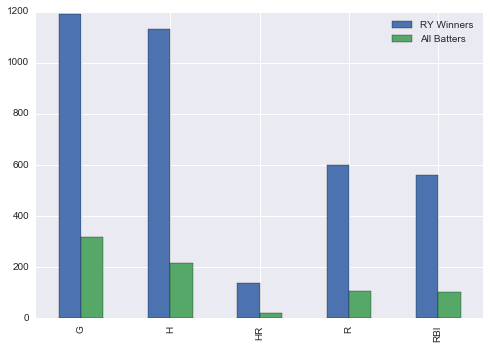

In [20]:
#9.2.1
'''
At Bats were intentionally left out, as its values would be far greater than those of the other statisitics and would
make the plot more difficult to view. Batting Average was also left out as its value would not be shown clearly, and
I will plot it below.
'''
batting_statistics_1 = pd.DataFrame({'RY Winners': batting_rookies_overall_means[['G', 'H','HR','R', 'RBI']],
                                     'All Batters': batting_df_overall_means[['G', 'H','HR','R', 'RBI']]},
                                     columns=['RY Winners','All Batters'])

batting_statistics_1.plot(kind='bar')
plt.show()

In [21]:
#9.3
#Apply the percentile function on the pitchers' statistics via a loop through each pitcher statistic.
pitching_statistics = ['G','W','IPouts','BFP','H','HR','SO','ER','BAopp','ERA']
for statistic in pitching_statistics:
    print statistic + ' = ' + str(percentile(pitching_df_career_totals[statistic], pitching_rookies_overall_means[statistic]))

G = 0.847070844687
W = 0.909400544959
IPouts = 0.898671662125
BFP = 0.895776566757
H = 0.890667574932
HR = 0.882152588556
SO = 0.91757493188
ER = 0.886069482289
BAopp = 0.26924386921
ERA = 0.541723433243


Follow up to step 9.3:
I believe some of these figures are misleading. Since RY winners typically faced so many more batters than an average pitcher, it makes sense that they have also given up many more Hits, Home Runs, and Earned Runs, on average. In terms of positive statistics for RY winners, they have played more games, have more wins, and more strikeouts than most other pitchers. 

9.3.1:
Plot the means of the statisitcs, to give a visual representation of the data and difference in values between RY winners and all other pitchers.

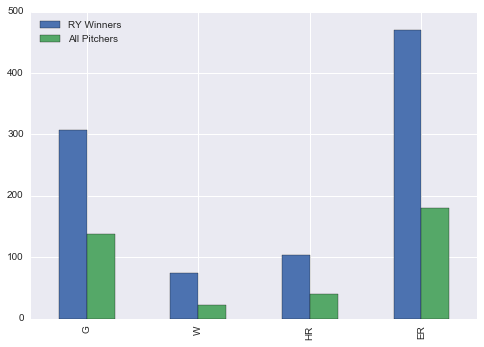

In [22]:
#9.3.1.1
# Statistics are grouped by relatively similar values - first set.
pitching_stats_1 = pd.DataFrame({'RY Winners': pitching_rookies_overall_means[['G','W','HR','ER']],
                    'All Pitchers': pitching_df_overall_means[['G','W','HR','ER']]},
                     columns=['RY Winners','All Pitchers'])

pitching_stats_1.plot(kind='bar')
plt.show()

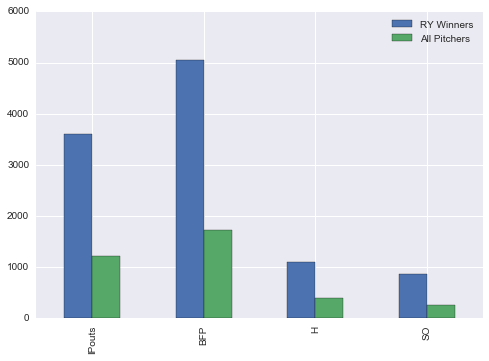

In [23]:
#9.3.1.2
# Statistics are grouped by relatively similar values - second set.
pitching_stats_2 = pd.DataFrame({'RY Winners': pitching_rookies_overall_means[['IPouts','BFP','H','SO']],
                    'All Pitchers': pitching_df_overall_means[['IPouts','BFP','H','SO']]},
                     columns=['RY Winners','All Pitchers'])

pitching_stats_2.plot(kind='bar')
plt.show()

Step 10: Inquiry about unexpected results.

In [24]:
#10.1
#Print the batting_rookies_career_totals to see if there are any unexpected players included.
#Set max_rows and max_columns to 999 to ensure all the data is visible.
with pd.option_context('display.max_rows', 999, 'display.max_columns', 999): 
    print batting_rookies_career_totals

      playerID     G       AB       H     HR       R     RBI       AVG
0    abreujo02   299   1169.0   354.0   66.0   168.0   208.0  0.302823
1     ageeto01  1129   3912.0   999.0  130.0   558.0   433.0  0.255368
2    allendi01  1749   6332.0  1848.0  351.0  1099.0  1119.0  0.291851
3    allisbo01  1541   5032.0  1281.0  256.0   811.0   796.0  0.254571
4    alomasa02  1377   4530.0  1236.0  112.0   520.0   588.0  0.272848
5    aparilu01  2601  10230.0  2677.0   83.0  1335.0   791.0  0.261681
6    bagweje01  2150   7797.0  2314.0  449.0  1517.0  1529.0  0.296781
7    bahnsst01   519    479.0    56.0    1.0    22.0    19.0  0.116910
8    bailean01   216      0.0     0.0    0.0     0.0     0.0       NaN
9      bayja01  1278   4505.0  1200.0  222.0   737.0   754.0  0.266371
10   beltrca01  2306   8749.0  2454.0  392.0  1449.0  1443.0  0.280489
11   benchjo01  2158   7658.0  2048.0  389.0  1091.0  1376.0  0.267433
12   berroan01   746   2575.0   665.0   46.0   329.0   254.0  0.258252
13   b

Followup to Step 10.1:
It appears that there are some AVG equal NaN. I will change these values to 0, because they have 0 hits.

Step 10.1.1: Change NaN values to 0.

In [25]:
#10.1.1
batting_rookies_career_totals = batting_rookies_career_totals.fillna(0)

In [26]:
#10.2
#Print the pitching_rookies_careet_totals to see if there are any unexpected players included.
#Set max_rows and max_columns to 999 to ensure all the data is visible.
with pd.option_context('display.max_rows', 999, 'display.max_columns', 999):
    print pitching_rookies_career_totals

     playerID    G    W   IPouts      BFP     H   HR    SO    ER     BAopp  \
0   bahnsst01  574  146   7587.0  10701.0  2440  223  1359  1013  0.228016   
1   bailean01  216   11    680.0    913.0   170   22   233    69  0.186199   
2   blackjo02  172   30   1242.0   1737.0   391   53   222   180  0.225101   
3    byrdha01  187   46   2483.0   3675.0   890   71   381   400  0.242177   
4   cansejo01    1    0      3.0      8.0     2    0     0     3  0.250000   
5    darkal01    1    0      3.0      5.0     1    1     0     2  0.200000   
6   degroja01   52   23    994.0   1316.0   266   23   349    96  0.202128   
7   felizne01  246   15    869.0   1168.0   208   26   265   102  0.178082   
8   fernajo02   47   22    867.0   1151.0   208   18   336    77  0.180712   
9   fidryma01   58   29   1237.0   1695.0   397   23   170   142  0.234218   
10  goodedw01  430  194   8402.0  11705.0  2564  210  2293  1091  0.219052   
11   grimbo01  268   61   2279.0   3234.0   708   50   443   305

Followup to Step 10.2:
It appears that there are three fielders included in the dataframe. I will remove them from the dataframe to calculate more accurate values of how well RY winning pitchers pitch. Fielders rarely pitch so it does not make a great deal of sense to include them in the dataframe.

In [27]:
#10.2.1
#Create a new dataframe without the fielders.
only_pitching_rookies_career_totals = pitching_rookies_career_totals[pitching_rookies_career_totals.G > 1]

In [28]:
#10.2.2
#Calculate the new pitching_rookies_overall_means.
only_pitching_rookies_overall_means = only_pitching_rookies_career_totals.mean()

In [29]:
#10.2.3
#Calculate the new percentiles.
pitching_statistics = ['G','W','IPouts','BFP','H','HR','SO','ER','BAopp','ERA']
for statistic in pitching_statistics:
    print statistic + ' = ' + str(percentile(pitching_df_career_totals[statistic], only_pitching_rookies_overall_means[statistic]))

G = 0.865803814714
W = 0.918085831063
IPouts = 0.910762942779
BFP = 0.908719346049
H = 0.901566757493
HR = 0.891178474114
SO = 0.927963215259
ER = 0.895265667575
BAopp = 0.215429155313
ERA = 0.165701634877


Followup to 10.2.3: These values, especially ERA, are much closer to those that I expected. I believe removing the three fielders from the dataframe have provided percentiles that are much more reflective of the skills of RY winning pitchers.

In [30]:
#10.2.4
#Subtract new values from the old ones to show the difference.
pitching_statistics = ['G','W','IPouts','BFP','H','HR','SO','ER','BAopp','ERA']
for statistic in pitching_statistics:
    print statistic + ' = ' + str(percentile(pitching_df_career_totals[statistic], 
                                             only_pitching_rookies_overall_means[statistic]) -
                                  percentile(pitching_df_career_totals[statistic], 
                                             pitching_rookies_overall_means[statistic]))

G = 0.0187329700272
W = 0.00868528610354
IPouts = 0.012091280654
BFP = 0.0129427792916
H = 0.0108991825613
HR = 0.00902588555858
SO = 0.0103882833787
ER = 0.0091961852861
BAopp = -0.0538147138965
ERA = -0.376021798365


Followup to 10.2.4: These values are similar to those prior, therefore I do not feel the need to make another set of plots. BAopp and ERA will be plotted later on.

Step 11: Adjust measurements:
The RY winners' Batting Average seems surprisingly low compared to the the other percentiles. I believe this is due to finding the mean of the players' batting averages, instead of finding the batting average of all of the At Bats (AB) of RY winners. Finding this new percentile will dilute the weight of pitchers who have batted, because they play less often, therefore bat less, and typically have a lower batting average. In short, this new measurement should provide a more accurate representation of how well RY winners bat.

In [31]:
#11.1
#Find the new value for AVG, by using the sum of all players' Hits (H) and At Bats (AB) statistics.
#Then divide the value of Hits by At Bats.
batting_rookies_new_AVG = batting_rookies_career_totals['H'].sum() / batting_rookies_career_totals['AB'].sum()

In [32]:
#11.2
#Find the new percentile for AVG.
print 'AVG = ' + str(percentile(batting_df_career_totals['AVG'], batting_rookies_new_AVG))

AVG = 0.801218724033


Followup to 11.2: This value is much closer to the other percentiles of the other batting statistics, and one that I believe is more accurate of the skill of RY winning batters.

In [33]:
#11.2.1 
#Subtract previous value from new value to show the difference, followed by their relative differences.
print "AVG: Difference = " + str(batting_rookies_new_AVG - batting_rookies_overall_means['AVG'])
print "AVG: % Difference = " + str((batting_rookies_new_AVG - batting_rookies_overall_means['AVG'])/ 
                              batting_rookies_overall_means['AVG']*100)

AVG: Difference = 0.036527506919
AVG: % Difference = 15.1165840091


Step 11.3
Compare RY winners' AVG, BAopp, and ERA to all other players via plots. 
I am using box plots to show the spread of these values, 
as I believe they are the most important in determining the quality of the players, 
thus a more accurate depiction of their values should be worthwhile.

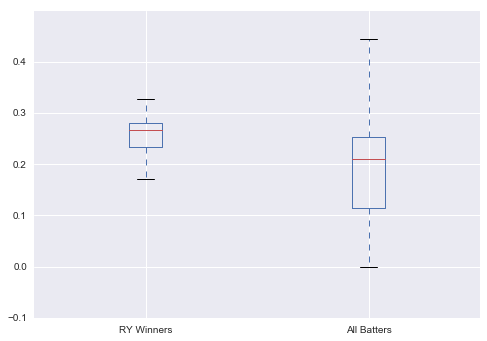

In [34]:
#11.3.1
#Compare RY winners' AVG to all other batters.
batting_statisitc_AVG = pd.DataFrame({'RY Winners': batting_rookies_career_totals['AVG'],
                                      'All Batters': batting_df_career_totals['AVG']},
                                      columns = ['RY Winners', 'All Batters'])

batting_statisitc_AVG.plot(kind='box', ylim = [-0.1,0.5])
plt.show()

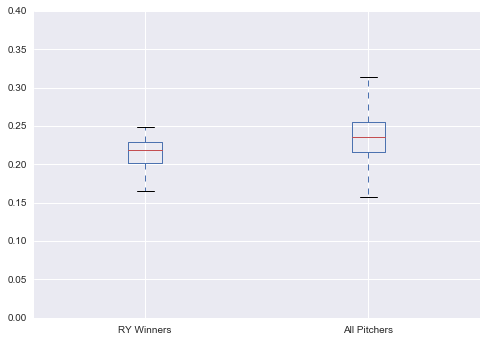

In [35]:
#10.3.2
#Compare RY winners' BAopp to all other pitchers.
pitching_stats_BAopp = pd.DataFrame({'RY Winners': only_pitching_rookies_career_totals['BAopp'],
                                     'All Pitchers': pitching_df_career_totals['BAopp']},
                                     columns=['RY Winners','All Pitchers'])

pitching_stats_BAopp.plot(kind='box', ylim = [0,0.4])
plt.show()

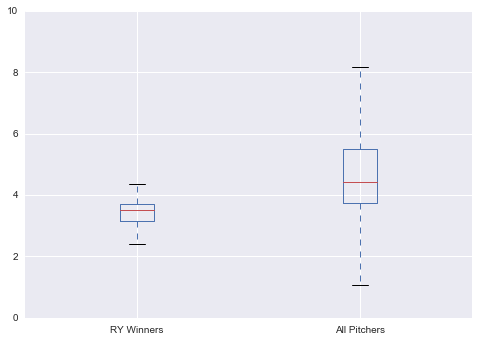

In [36]:
#10.3.3
#Compare RY winners' ERA to all other pitchers.
pitching_stats_ERA = pd.DataFrame({'RY Winners': only_pitching_rookies_career_totals['ERA'],
                                   'All Pitchers': pitching_df_career_totals['ERA']},
                                   columns=['RY Winners','All Pitchers'])

pitching_stats_ERA.plot(kind='box', ylim = [0,10])
plt.show()

The Goal (1) Summary:
I believe that it is clear to say that RY winners have above average careers in the MLB. In all the measurements that were used to compare RY winners with all other MLB players, they performed well above average, regularly in the 90th+ percentile.

Step 11: Calculate if RY winners are improving with time.

In [37]:
#11.1
#Create new dataframes for the yearly calculations.
yearly_batting_rookies = ry_winners.merge(batting_df,
                                         how = 'left',
                                         on = 'playerID')

yearly_pitching_rookies = ry_winners.merge(pitching_df,
                                           how = 'inner',
                                           on = 'playerID')

In [38]:
#11.2
#Include only the relevant statistics in the dataframes.
yearly_batting_rookies = yearly_batting_rookies[['yearID','G','AB','H','HR','R','RBI']]
yearly_pitching_rookies = yearly_pitching_rookies[['yearID','G','W','IPouts','BFP','H','HR','SO','ER']]

In [39]:
#11.3
#Group statistics by year to calculate the yearly changes.
yearly_batting_rookies_career_totals = yearly_batting_rookies.groupby('yearID', as_index = False).sum()
yearly_pitching_rookies_career_totals = yearly_pitching_rookies.groupby('yearID', as_index = False).sum()

In [40]:
#11.4 
#Create empty dataframes to be filled with standardized values.
yearly_batting_rookies_career_totals_standardized = pd.DataFrame()
yearly_pitching_rookies_career_totals_standardized = pd.DataFrame()

In [41]:
#11.5.1.1
'''
Add the standardized values to the empty dataframes. 
Batters are standardized by At Bats, because this will show how successful a batter is at each At Bat and 
if there are different amount of At Bats each season, the yearly differences will be factored out.
'''
yearly_batting_statistics = ['G','AB','H','HR','R','RBI']
for statistic in yearly_batting_statistics:
    yearly_batting_rookies_career_totals_standardized[statistic] = (yearly_batting_rookies_career_totals[statistic] /
                                                                    yearly_batting_rookies_career_totals['AB'])

In [42]:
#11.5.1.2
#Calculate and add AVG to the batting standardized values dataframe.
yearly_batting_rookies_career_totals_standardized['AVG'] = (yearly_batting_rookies_career_totals['H'] /
                                               yearly_batting_rookies_career_totals['AB'])

In [43]:
#11.5.2.1
'''
Add the standardized values to the empty dataframes.
Pitchers are standardized by Batters Faced, 
because this will show how successful a pitcher typically is against a batter, 
and if pitchers face a different amount of batters each year, this will be factored out.
'''
yearly_pitching_statistics = ['G','W','IPouts','BFP','H','HR','SO','ER']
for statistic in yearly_pitching_statistics:
    yearly_pitching_rookies_career_totals_standardized[statistic] = (yearly_pitching_rookies_career_totals[statistic] / 
                                                                     yearly_pitching_rookies_career_totals['BFP'])

In [44]:
#11.5.2.2
#Calculate and add BAopp and ERA to the pitching standardized values dataframe.
yearly_pitching_rookies_career_totals_standardized['BAopp'] = (yearly_pitching_rookies_career_totals['H'] /
                                                  yearly_pitching_rookies_career_totals['BFP'])
yearly_pitching_rookies_career_totals_standardized['ERA'] = (yearly_pitching_rookies_career_totals['ER'] /
                                                (yearly_pitching_rookies_career_totals['IPouts'] / 27))

In [45]:
#11.6
#Add the years (yearID) to the dataframes.
yearly_batting_rookies_career_totals_standardized['yearID'] = yearly_batting_rookies_career_totals['yearID']
yearly_pitching_rookies_career_totals_standardized['yearID'] = yearly_pitching_rookies_career_totals['yearID']

In [46]:
#11.7
#Calculate the correlation for batters.
yearly_batting_rookies_career_totals_standardized.corr()

,G,AB,H,HR,R,RBI,AVG,yearID
G,1.000000,NaN,-0.348781,-0.288255,-0.429037,-0.032460,-0.348781,0.172644
AB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H,-0.348781,NaN,1.000000,0.361156,0.832639,0.436682,1.000000,0.061390
HR,-0.288255,NaN,0.361156,1.000000,0.570076,0.900936,0.361156,0.227543
R,-0.429037,NaN,0.832639,0.570076,1.000000,0.518495,0.832639,0.108133
RBI,-0.032460,NaN,0.436682,0.900936,0.518495,1.000000,0.436682,0.225669
AVG,-0.348781,NaN,1.000000,0.361156,0.832639,0.436682,1.000000,0.061390
yearID,0.172644,NaN,0.061390,0.227543,0.108133,0.225669,0.061390,1.000000


Follow up to 11.7:
By looking at the yearID column/row, we can see that RY winning batters, on average, improve in all areas with each successive year.

In [47]:
#11.8
#Calculate the correlation for pitchers.
yearly_pitching_rookies_career_totals_standardized.corr()

,G,W,IPouts,BFP,H,HR,SO,ER,BAopp,ERA,yearID
G,1.000000,-0.398919,-0.077348,NaN,-0.069148,0.212708,0.096844,0.216759,-0.069148,0.223468,0.320711
W,-0.398919,1.000000,0.751863,NaN,-0.441512,-0.533458,0.540934,-0.765019,-0.441512,-0.774742,0.034162
IPouts,-0.077348,0.751863,1.000000,NaN,-0.590532,-0.485380,0.767301,-0.801075,-0.590532,-0.813054,0.322662
BFP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H,-0.069148,-0.441512,-0.590532,NaN,1.000000,-0.181902,-0.709215,0.261430,1.000000,0.279431,-0.083578
HR,0.212708,-0.533458,-0.485380,NaN,-0.181902,1.000000,-0.353812,0.882490,-0.181902,0.870750,-0.277637
SO,0.096844,0.540934,0.767301,NaN,-0.709215,-0.353812,1.000000,-0.633312,-0.709215,-0.640417,0.615613
ER,0.216759,-0.765019,-0.801075,NaN,0.261430,0.882490,-0.633312,1.000000,0.261430,0.999432,-0.272141
BAopp,-0.069148,-0.441512,-0.590532,NaN,1.000000,-0.181902,-0.709215,0.261430,1.000000,0.279431,-0.083578
ERA,0.223468,-0.774742,-0.813054,NaN,0.279431,0.870750,-0.640417,0.999432,0.279431,1.000000,-0.269192


Follow up to 11.8:
By looking at the yearID column/row, we can see that RY winning pitchers also, on average, improve with each successive year. H, HR, ER, BAopp, and ERA all have negative values, which means that pitchers are giving up fewer hits, home runs, and earned runs, and they are playing more games, winning more games, and striking out more players, on average, with each passing year.

Summary of Goal 2:
It appears that RY winners are becoming better batters and pitchers, on average, with each passing year, based on the correlation between years and each statistic.

Overall Summary:
I am quite pleased to have answered both of my questions and received the conclusive evidence that I did. Based on these statisitcs, it appears that RY winners are excellent baseball players and are improving over time.

Limitations to Analysis:
1: There is a possibility that I overweighted the better batters in terms of their Batting Averages. By summing the values of the RY winners before calculating AVG, this could overrepresent the better batters, as they bat more often. The main reason I did this, was to underweight the pitchers who have batted. Another option would have been to caluculate the median value for the Batting Average (see below), however, this does not significantly alter the percentile, so I do not think that I have made a misleading analysis with my calculations.

2: It could have been worth comparing RY winners to players that have played at least 200 games, for example. These players could be considered 'regular' MLB players who are more 'worthy' of a comparison. By comparing RY winners to these 'regular' MLB players, it could be a more accurate comparison for the true relative skill of RY winners. I thought this analysis was not essential because I found the percentile for each statistic comparing RY winners to all other players. I believe these percentiles are sufficient in answering the original question: To see if winners of 'Rookie of the Year' (RY) have above average careers.

3: I did not calculate if there was a trend in the MLB of the average player becoming better overtime. If the average player is becoming relatively better than the average RY winner, then one could argue that the average RY winner is becoming relatively worse overtime. I do not think that this calculation is necessary because it is not essential to answer part 2 of the original question: To see if there is a trend of each winner of RY being better than the previous winner. The correlations found show that RY winners are becoming better over time, which answers the question. Plus, I cannot think of a reason why RY winners would become relatively worse over time. 

4: I did not remove fielders from pitching_df_career_totals. This could underscore the quality of pitchers in the MLB, but because fielders so rarely pitch in the MLB, I am not worried that I have created a misleading analysis and over-valued the skills of RY winning pitchers.

In [49]:
#Followup to limitation 1.
print percentile(batting_df_career_totals['AVG'], batting_rookies_career_totals['AVG'].median())

0.748499676853


Reason for these questions:
During the 2003-2004 NHL season, Andrew Raycroft, a goalie for the Boston Bruins, played a fantastic season and won the Calder Memorial Trophy (aka Rookie of the Year). During the summer of 2006, the Toronto Maple Leafs (my favourite team) traded for Raycroft. Raycroft never played another particularly good season for the remaineder of his NHL career. I was wondering if this was a trend, RY winners being average players, or if Raycroft was more of an exception. I can't say anything about the NHL, but I can safely say that there is a trend in RY winners being exceptional players in the MLB.

List of websites used to help perform analysis:
http://stackoverflow.com/
http://pandas.pydata.org/pandas-docs/stable/index.html
https://www.quora.com/
https://en.wikipedia.org/wiki/Main_Page
http://www.baseball-reference.com/